## Setup

In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from harp_resources import process, utils
from sleap import load_and_process as lp

In [2]:
data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_220824/2024-08-22T13-13-15_B3M6')
photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_220824/photometry/B3M6_MMclosed&Regular_day1/2024_08_22-15_16_40')
#preprocessed photometry data should go in the same folder, currently manually matched with Hilde's google drive 

## Videography and SLEAP

In [3]:
# lp.create_flipped_videos(data_path, what_to_flip='VideoData1')

In [4]:
VideoData1, VideoData2 = lp.load_videography_data(data_path)

INFO:
load_and_process.load_videography_data() function expects the following format of SLEAP outputs:
"VideoData1_1904-01-01T00-00-00.sleap.csv"
"VideoData1_1904-01-01T23-59-59.sleap.csv"
"..."
Please make sure to rename SLEAP files if they are not already following this convention.


RESULTS:
Outputs of SLEAP found in VideoData1: False
Outputs of SLEAP found in VideoData2: True
Found .csv VideoData logs timestamped at:
- 1904-01-05T02:00:00.000000000
Reading dataframes finished.
VideoData2 SLEAP output: 114387 frames registered, but 114202 rows found inside file. Filling with empty rows.


In [5]:
# SLEAP processing

VideoData2 = VideoData2.interpolate()

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']
coordinates_dict = lp.get_coordinates_dict(VideoData2, columns_of_interest)

theta = lp.find_horizontal_axis_angle(VideoData2, 'left', 'center')
center_point = lp.get_left_right_center_point(coordinates_dict)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
remformatted_coordinates_dict = lp.get_reformatted_coordinates_dict(coordinates_dict, columns_of_interest)
centered_coordinates_dict = lp.get_centered_coordinates_dict(remformatted_coordinates_dict, center_point)
rotated_coordinates_dict = lp.get_rotated_coordinates_dict(centered_coordinates_dict, theta)

columns_of_interest = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
ellipse_parameters_data, ellipse_center_points_data = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict, columns_of_interest)

SleapData = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData2['Seconds'].values, ellipse_parameters_data[:,0], ellipse_parameters_data[:,1], ellipse_parameters_data[:,2], ellipse_center_points_data[:,0], ellipse_center_points_data[:,1]])

## Loading and Synchronisation

In [6]:
conversions = process.calculate_conversions_second_approach(data_path, photometry_path, verbose=False)

OnixAnalogClock loaded in 0.78 seconds.
Calculation of conversions finished in 11.91 seconds.


In [7]:
streams = utils.load_registers(data_path)

# Photometry = utils.read_fluorescence(photometry_path)
Photometry = pd.read_csv('/home/ikharitonov/Downloads/preprocessed_grab2.csv')
Photometry['TimeStamp'] = Photometry['TimeStamp'] * 1000
Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])

streams = process.reformat_and_add_many_streams(streams, Photometry, 'Photometry', ['470_dfF'], index_column_name='HARP Timestamps')
streams = process.reformat_and_add_many_streams(streams, SleapData, 'Eye Movements', ['Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'])

_ = process.get_timepoint_info(streams, print_all=True)
resampled_streams = process.pad_and_resample(streams, resampling_period='0.1ms', method='linear')
_ = process.get_timepoint_info(resampled_streams, print_all=True)

Dataset 2024-08-22T13-13-15_B3M6 contains following registers:
H1: [33, 32, 46]
H2: [39, 42]
Registers loaded in 1.45 seconds.
Global first timestamp: 1904-01-05 02:08:50.632352
Global last timestamp: 1904-01-05 02:40:44.168925404
Global length: 0 days 00:31:53.536573404

H1
Cam1Event(33): 
	first  1904-01-05 02:08:51.182336 
	last   1904-01-05 02:40:37.417280 
	length 0 days 00:31:46.234944 
	mean difference between timestamps 0 days 00:00:00.016666097
Cam0Event(32): 
	first  1904-01-05 02:08:51.182304 
	last   1904-01-05 02:40:37.417280 
	length 0 days 00:31:46.234976 
	mean difference between timestamps 0 days 00:00:00.016666098
OpticalTrackingRead0X(46): 
	first  1904-01-05 02:08:51.190240 
	last   1904-01-05 02:40:37.430240 
	length 0 days 00:31:46.240000 
	mean difference between timestamps 0 days 00:00:00.010000
OpticalTrackingRead0Y(46): 
	first  1904-01-05 02:08:51.190240 
	last   1904-01-05 02:40:37.430240 
	length 0 days 00:31:46.240000 
	mean difference between timestamps 0

OnixAnalogClock loaded in 0.81 seconds.
OnixAnalogData loaded in 35.59 seconds.
Selection of photodiode data finished in 0.77 seconds.


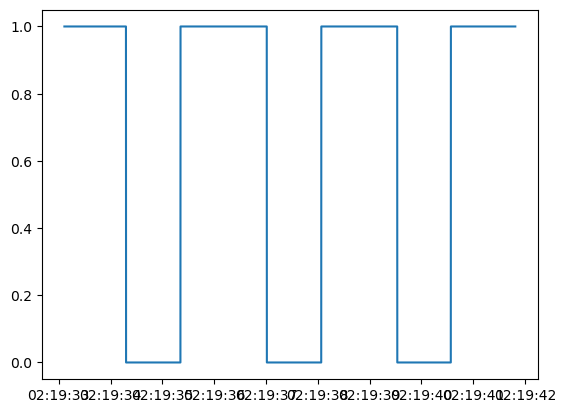

In [8]:
# Loading data
OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
OnixAnalogData = utils.read_OnixAnalogData(data_path, binarise=True)
ExperimentEvents = utils.read_ExperimentEvents(data_path)

# Selecting desired HARP times, applying conversion to ONIX time
start_harp_time_of_halt_one = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[0].Seconds
start_harp_time_of_halt_four = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[3].Seconds

# Selecting photodiode times and data within the range, converting back to HARP and plotting
selected_harp_times, selected_photodiode_data = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, start_harp_time_of_halt_one - 1, start_harp_time_of_halt_four, conversions)

plt.plot(selected_harp_times, selected_photodiode_data[:, 0])
plt.show()

## Usage

In [9]:
#LOAD CSV FILE SAVED FROM STEP 1 

In [10]:
from scipy import signal

In [11]:
def moving_avarage_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

In [56]:
running = resampled_streams['H1']['OpticalTrackingRead0X(46)']
# running = moving_avarage_smoothing(running,50)
photometry = resampled_streams['Photometry']['470_dfF']
eye_movements = resampled_streams['Eye Movements']['Ellipse.Center.X']

In [57]:
def running_unit_conversion(running_array):
    resolution = 12000 # counts per inch
    inches_per_count = 1 / resolution
    meters_per_count = 0.0254 * inches_per_count
    dt = 0.01 # for OpticalTrackingRead0Y(46)
    linear_velocity = meters_per_count / dt # meters per second per count
    
    # ball_radius = 0.1 # meters 
    # angular_velocity = linear_velocity / ball_radius # radians per second per count
    # angular_velocity = angular_velocity * (180 / np.pi) # degrees per second per count
    # print(angular_velocity)

    return running_array * linear_velocity

In [58]:
running = running_unit_conversion(running) # meters per second
running *= 100 # centimeters per second

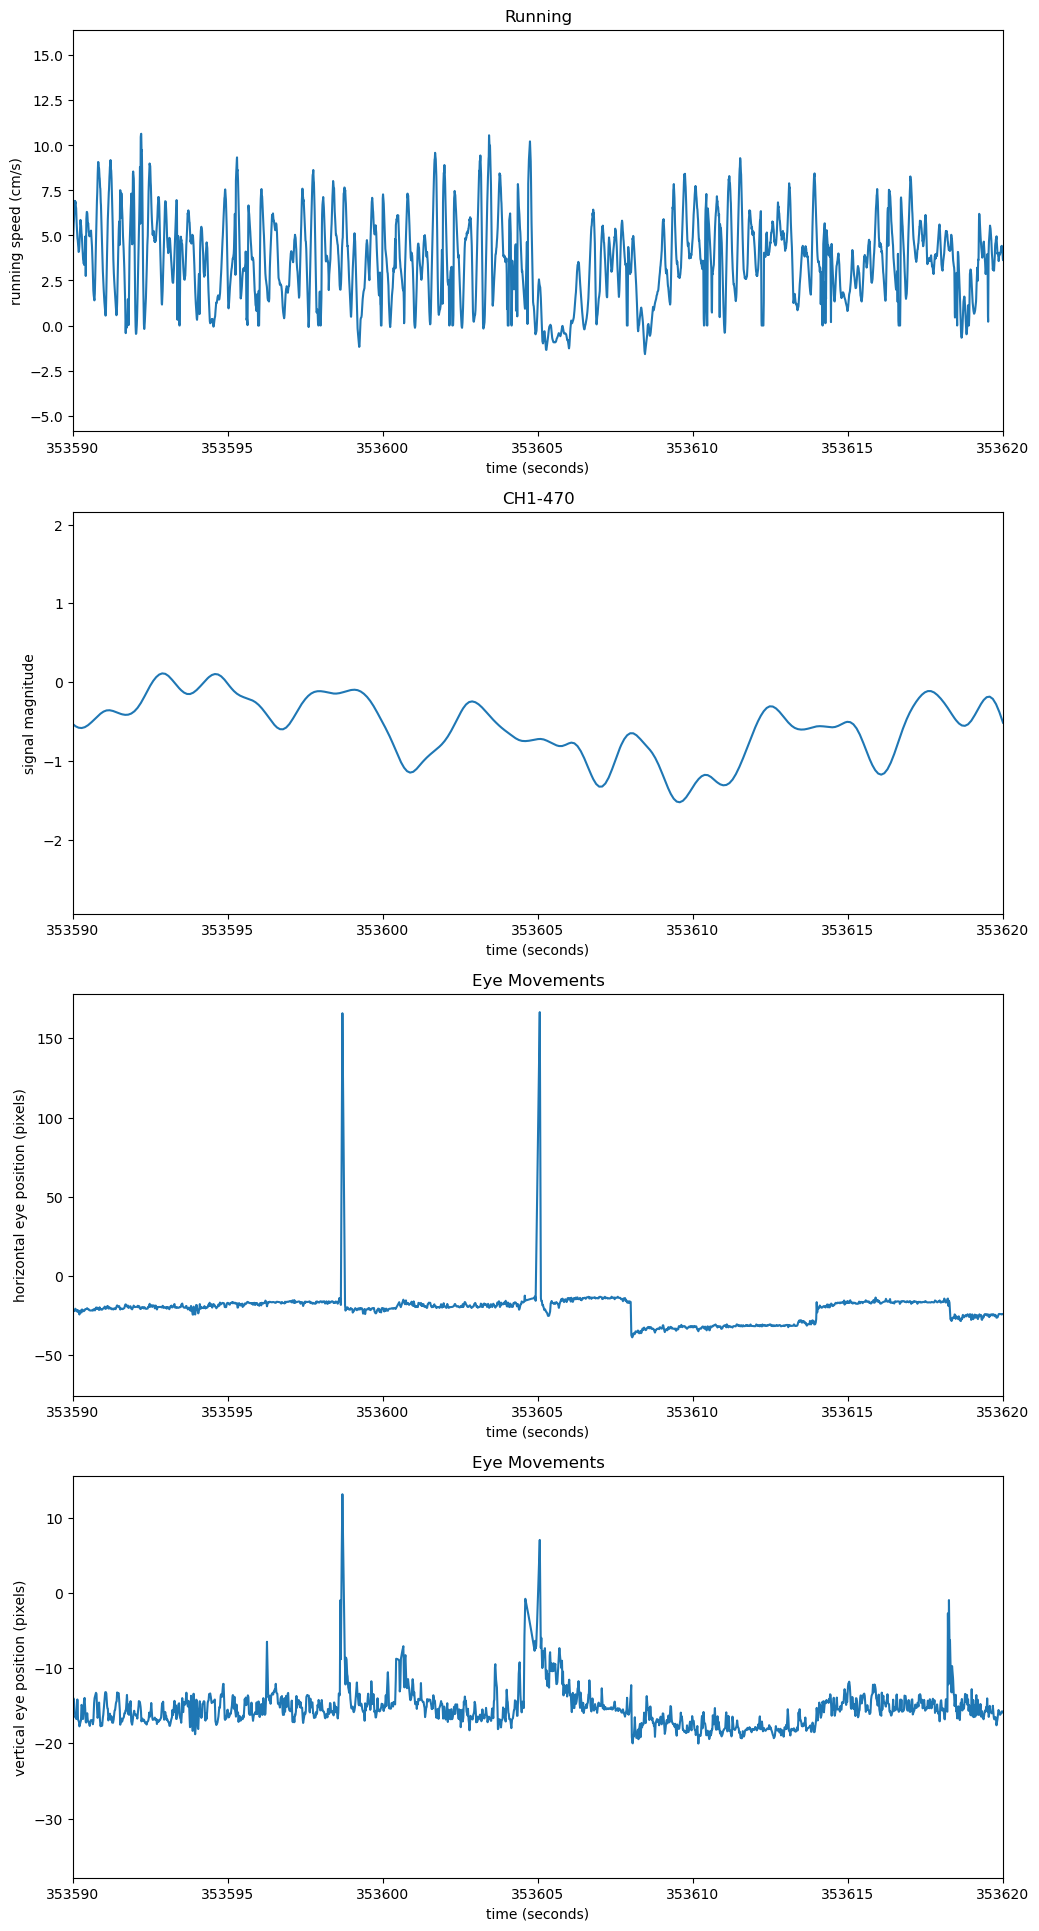

In [59]:
#A = None
#B = None
A = 353590
B = A + 30

# photodiode_x, photodiode_y = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, A, B, conversions)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,24))

t = (eye_movements.index - utils.harp.REFERENCE_EPOCH).total_seconds()

ax[0].plot(t, running)
ax[0].set_title('Running')
ax[0].set_xlim([A,B])
ax[0].set_xlabel('time (seconds)')
ax[0].set_ylabel('running speed (cm/s)')

ax[1].plot(t, photometry)
ax[1].set_title('CH1-470')
ax[1].set_xlim([A,B])
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('signal magnitude')

# ax[1].plot(t, resampled_streams['H2']['Encoder(38)'])
# ax[1].set_title('CH1-470')
# ax[1].set_xlim([A,B])
# ax[1].set_xlabel('time (seconds)')
# ax[1].set_ylabel('signal magnitude')

ax[2].plot(t, eye_movements)
ax[2].set_title('Eye Movements')
ax[2].set_xlim([A,B])
ax[2].set_xlabel('time (seconds)')
ax[2].set_ylabel('horizontal eye position (pixels)')

ax[3].plot(t, resampled_streams['Eye Movements']['Ellipse.Center.Y'])
ax[3].set_title('Eye Movements')
ax[3].set_xlim([A,B])
ax[3].set_xlabel('time (seconds)')
ax[3].set_ylabel('vertical eye position (pixels)')

# ax[3].plot(process.convert_datetime_to_seconds(photodiode_x), photodiode_y[:,0])
# ax[3].set_title('Photodiode')
# ax[3].set_xlim([A,B])
# ax[3].set_xlabel('time (seconds)')
# ax[3].set_ylabel('photodiode signal')

plt.show()

In [61]:
ExperimentEvents.Value.unique()

array(['Sync signal started', 'LinearNormal block started',
       'Homing platform', 'Wait for run threshold...',
       'Check halt probability', 'No halt', 'Block timer elapsed',
       'LinearRegularMismatch block started', 'Halt delay: 1s',
       'Apply halt: 1s', 'LinearMismatch block started'], dtype=object)

In [62]:
ExperimentEvents = utils.read_ExperimentEvents(data_path)

# A = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[0].Seconds
# B = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[-1].Seconds

# A = ExperimentEvents.iloc[0].Seconds
# B = ExperimentEvents.iloc[-1].Seconds

A = ExperimentEvents[ExperimentEvents.Value=='LinearMismatch block started'].iloc[0].Seconds #move this to the top (first cell)
B = ExperimentEvents.iloc[-1].Seconds

# A = 354900
# B = A+200

print(A, B)
print(process.convert_seconds_to_datetime(A), process.convert_seconds_to_datetime(B))

354601.600256 355229.800832
1904-01-05 02:30:01.600256 1904-01-05 02:40:29.800832


In [63]:
selected_harp_times, selected_photodiode_data = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, A, B, conversions)

Selection of photodiode data finished in 19.79 seconds.


In [147]:
# Converting photodiode data into a pd.Series

photodiode_stream = pd.Series(data=selected_photodiode_data[:,0], index=selected_harp_times)

In [64]:
#should be a funtion 
t = (selected_harp_times - utils.harp.REFERENCE_EPOCH).total_seconds()

photodiode_low_state_times = t[np.where(selected_photodiode_data[:,0]==0)].to_numpy()
intervals_between_states = np.diff(photodiode_low_state_times)

threshold = intervals_between_states.mean() + 1 * intervals_between_states.std()

inds = np.where(intervals_between_states >= threshold)[0] + 1
halt_times = photodiode_low_state_times[inds]

In [65]:
resampled_streams['Eye Movements'].keys()

dict_keys(['Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'])

In [136]:
def select_perievent_segment(trace, event_times, range_around_event):
    
    selected_trace_chunks = []
    
    for event_time in event_times:
        
        start = event_time + range_around_event[0]
        end = event_time + range_around_event[1]
        
        selected_trace_chunks.append(trace.loc[start:end])
        
    return np.array(selected_trace_chunks)

def baseline_subtract_trace_on_selected_range(time_array, trace_array, time_range):
    inds = np.where(np.logical_and(time_array >= time_range[0], time_array < time_range[1]))
    baselines = trace[:, inds].squeeze().mean(axis=1)
    baselines = baselines.repeat(trace_array.shape[1]).reshape(trace_array.shape)
    return trace_array - baselines

In [171]:
# averaged_pupil_diameter_stream = pd.Series(np.mean(np.stack((resampled_streams['Eye Movements']['Ellipse.Width'], resampled_streams['Eye Movements']['Ellipse.Height'])), axis=0), index=resampled_streams['Eye Movements']['Ellipse.Height'].index)
averaged_pupil_diameter_stream

1904-01-05 02:08:50.632300    22.900467
1904-01-05 02:08:50.632400    22.900190
1904-01-05 02:08:50.632500    22.899913
1904-01-05 02:08:50.632600    22.899637
1904-01-05 02:08:50.632700    22.899360
                                ...    
1904-01-05 02:40:44.168500     0.001625
1904-01-05 02:40:44.168600     0.001219
1904-01-05 02:40:44.168700     0.000813
1904-01-05 02:40:44.168800     0.000406
1904-01-05 02:40:44.168900     0.000000
Freq: 100us, Length: 19135367, dtype: float64

In [178]:
range_around_halt = [-5,11]

# Selecting perievent segments
selected_chunks = {}
select_perievent_segment_func = lambda x: select_perievent_segment(process.convert_stream_from_datetime_to_seconds(x), halt_times, range_around_halt)
selected_chunks['GRAB df/F'] = select_perievent_segment_func(resampled_streams['Photometry']['470_dfF'])
selected_chunks['Running'] = select_perievent_segment_func(running)
selected_chunks['Horizontal eye movement'] = select_perievent_segment_func(resampled_streams['Eye Movements']['Ellipse.Center.X'])
selected_chunks['Vertical eye movement'] = select_perievent_segment_func(resampled_streams['Eye Movements']['Ellipse.Center.X'])
# selected_chunks['Pupil diameter width'] = select_perievent_segment_func(resampled_streams['Eye Movements']['Ellipse.Width'])
# selected_chunks['Pupil diameter height'] = select_perievent_segment_func(resampled_streams['Eye Movements']['Ellipse.Height'])
selected_chunks['Pupil diameter'] = select_perievent_segment_func(averaged_pupil_diameter_stream)

In [179]:
# Baselining the selected segments
time_range = [-1, 0] # in relation to the event
t = np.linspace(range_around_halt[0], range_around_halt[1], selected_chunks['GRAB df/F'].shape[1])

for name, trace in selected_chunks.items():
    selected_chunks[name] = baseline_subtract_trace_on_selected_range(t, trace, time_range)

In [180]:
# Avoiding to baseline the Photodiode
selected_chunks['Photodiode'] = select_perievent_segment_func(photodiode_stream)

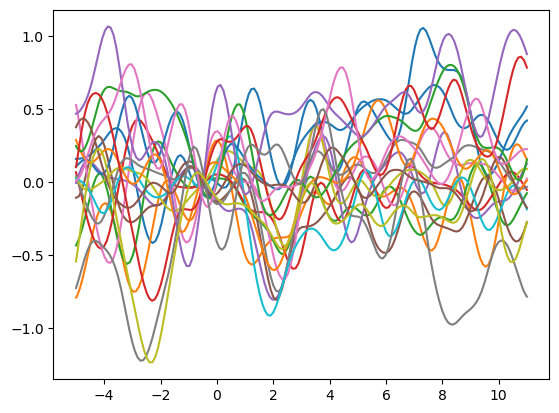

In [181]:
plt.figure()
for i in range(selected_chunks['GRAB df/F'].shape[0]): plt.plot(np.linspace(range_around_halt[0], range_around_halt[1], selected_chunks['GRAB df/F'].shape[1]), selected_chunks['GRAB df/F'][i,:])
plt.show()

In [182]:
ylabels = [
    'GRAB df/F (%)',
    'speed (cm/s)',
    'horizontal coordinga (pixels)',
    'vertical coordinate (pixels)',
    'pupli diameter (pixels)',
    'photodiode state'
]

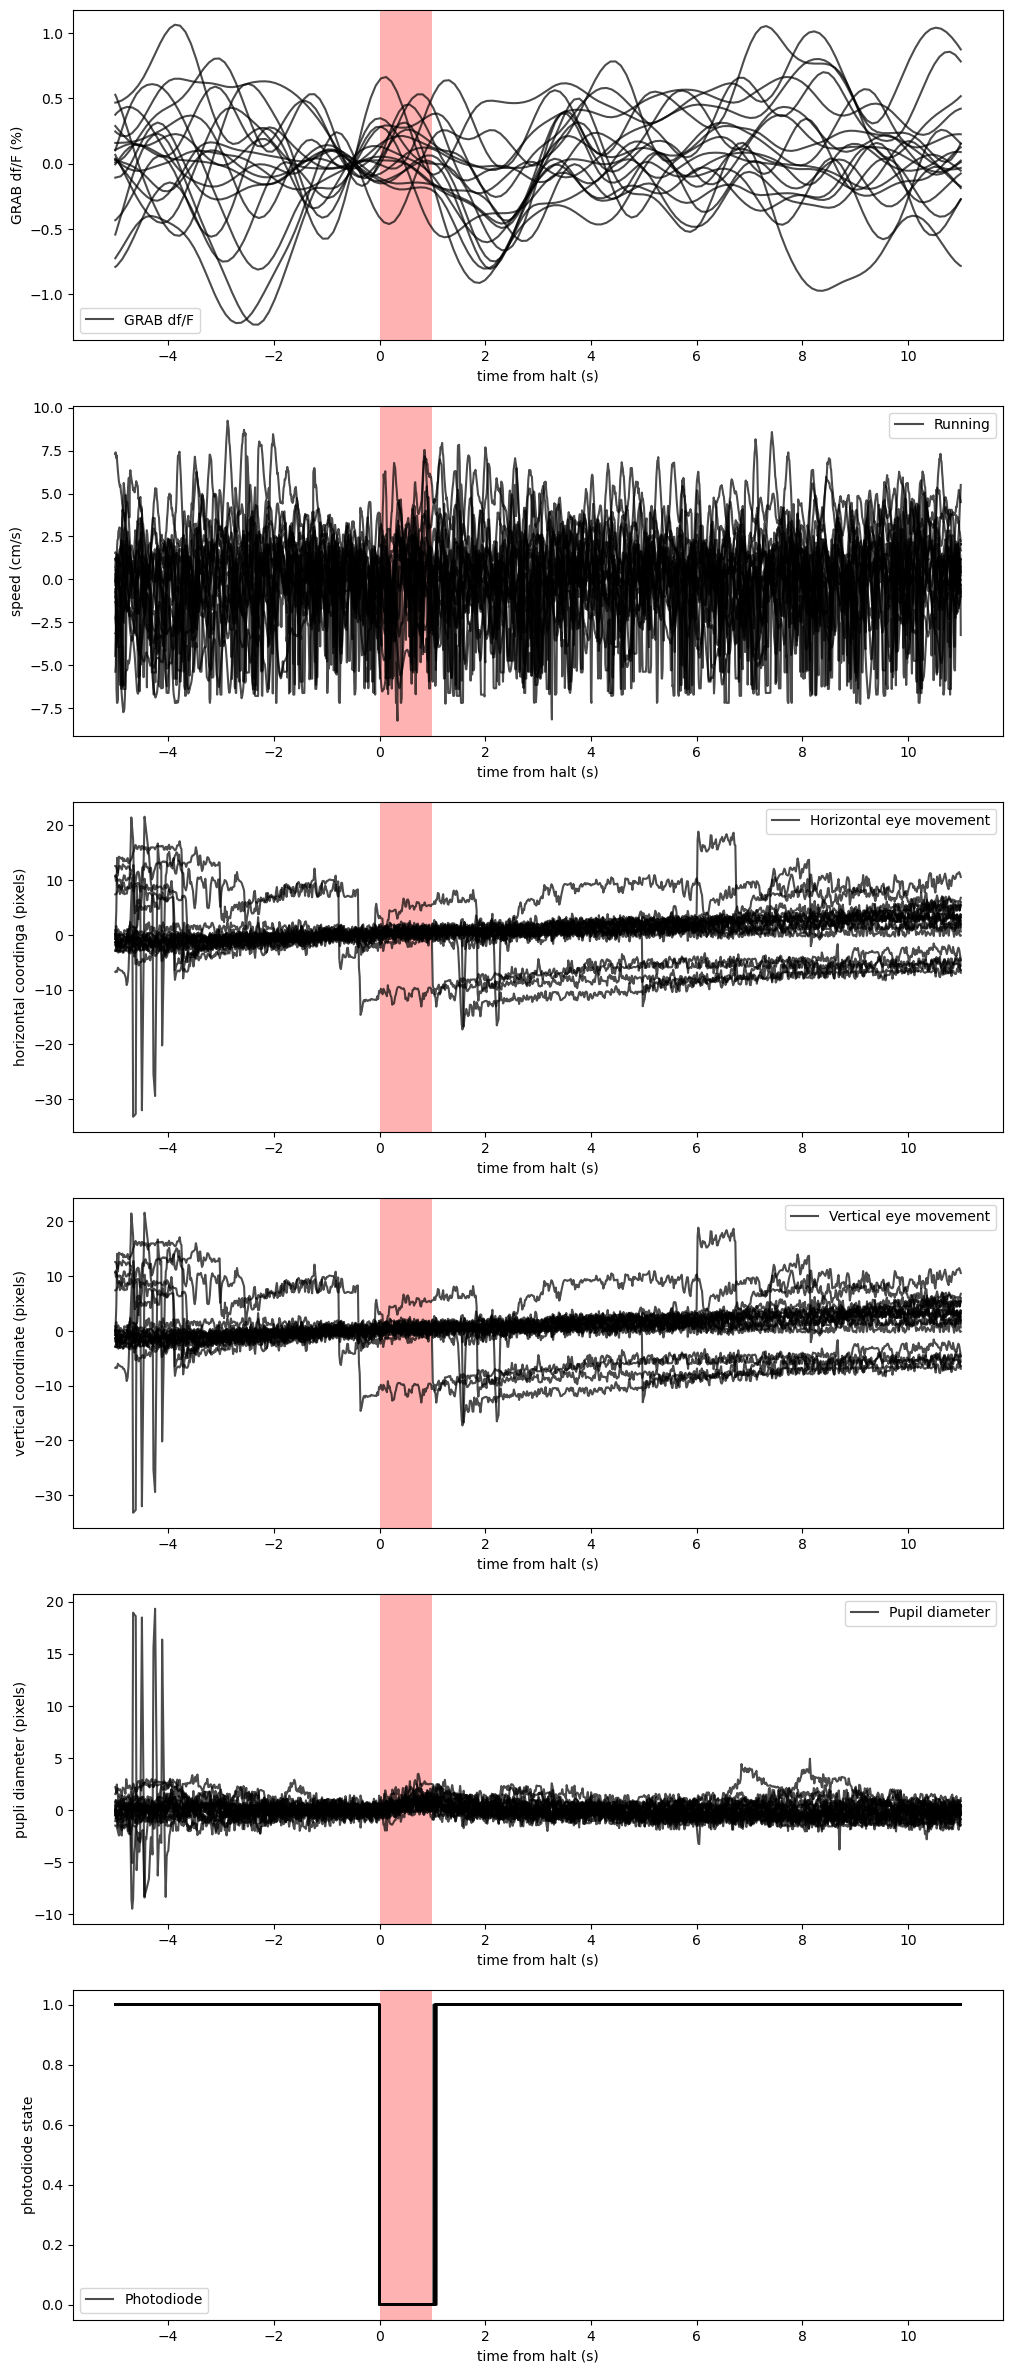

In [183]:
fig, ax = plt.subplots(nrows=len(selected_chunks), ncols=1, figsize=(12,(len(selected_chunks)-1)*6))

for i, (label, trace) in enumerate(selected_chunks.items()):
    t = np.linspace(range_around_halt[0], range_around_halt[1], trace.shape[1])
    ax_traces = []
    for j in range(trace.shape[0]):
        ax_traces.append(ax[i].plot(t, trace[j, :], c='black', alpha=0.7))
    ax_traces[-1][0].set_label(label) # assign a label to a single trace only
    ax[i].add_patch(patches.Rectangle((0, ax[i].get_ylim()[0]), 1, ax[i].get_ylim()[1]-ax[i].get_ylim()[0], edgecolor='none',facecolor='red', alpha=0.3))
    ax[i].legend()
    ax[i].set_xlabel('time from halt (s)')
    ax[i].set_ylabel(ylabels[i])

plt.show()